In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
import yfinance as yf
from scipy.interpolate import interp1d
from scipy.integrate import trapz

In [152]:
def option_value(option_type, S, K, sigma, t=0, r=0):
    """
    Calculate the value of an option using the Black-Scholes model
    
    :param option_type: "call"/"c" or "put"/"p"
    :type option_type: str
    :param S: price of the underlying
    :type S: float
    :param K: strike price of option
    :type K: float
    :param sigma: input implied volatility
    :type sigma: float
    :param t: time to expiration
    :type t: float, optional
    :param r: risk-free rate
    :type r: float, optional
    """
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
        d2 = d1 - sigma * np.sqrt(t)
    if option_type.lower() in {"c", "call"}:
        return np.multiply(norm.cdf(d1),S) - np.multiply(norm.cdf(d2), K * np.exp(-r * t))
    elif option_type.lower() in {"p", "put"}:
        return -np.multiply(norm.cdf(-d1), S) + np.multiply(norm.cdf(-d2), K * np.exp(-r * t))

In [153]:
calls = pd.read_excel("SPY_191020exp_290920.xlsx", sheet_name="call")
calls["midprice"] = (calls.bid + calls.ask)/2
calls = calls[calls.midprice > 0]
calls

,strike,lastPrice,change,bid,ask,BxA,volume,openInterest,midprice
0,170,0.00,0.0,163.70,164.06,146 x 146,0,0,163.880
1,175,0.00,0.0,158.70,159.06,146 x 146,0,0,158.880
2,180,0.00,0.0,153.69,154.05,146 x 102,0,0,153.870
3,185,0.00,0.0,148.70,149.04,146 x 102,0,0,148.870
4,190,0.00,0.0,143.70,144.06,146 x 146,0,0,143.880
...,...,...,...,...,...,...,...,...,...
110,405,0.01,0.0,0.00,0.01,0 x 11065,0,28,0.005
111,410,0.02,0.0,0.00,0.01,0 x 8620,0,200,0.005
112,415,0.01,0.0,0.00,0.01,0 x 8630,0,5,0.005
113,420,0.02,0.0,0.00,0.01,0 x 8641,0,55,0.005


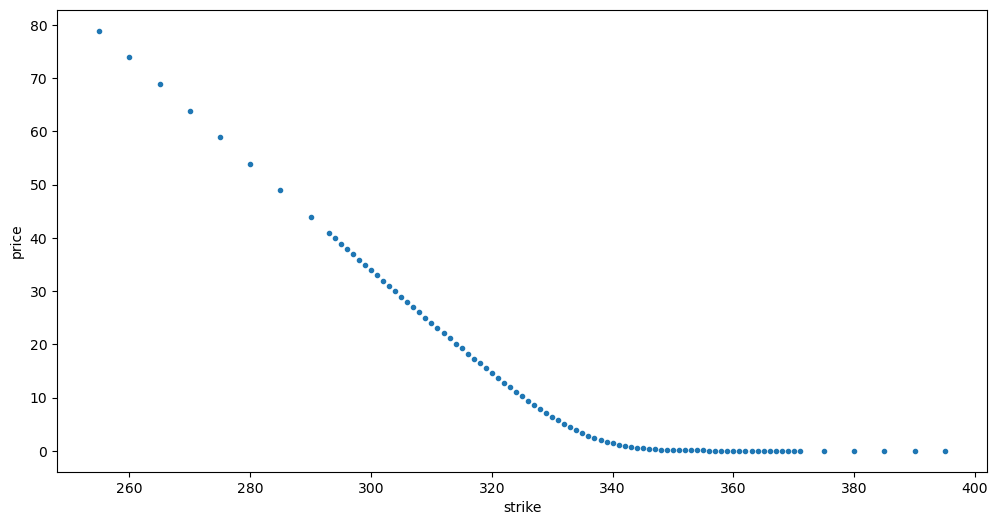

In [154]:
calls_sub = calls[(calls.strike > 250) & (calls.strike < 400)]
plt.figure(figsize=(12,6))
plt.plot(calls_sub.strike, calls_sub.midprice, ".");
plt.xlabel("strike")
plt.ylabel("price")
plt.savefig("call_prices.png", dpi=400)
plt.show()

## Implied Volatility Surface

In [155]:
def call_value(S, K, sigma, t=0, r=0):
    # use np.multiply and divide to handle divide-by-zero
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
        d2 = d1 - sigma * np.sqrt(t)
    return np.multiply(norm.cdf(d1),S) - np.multiply(norm.cdf(d2), K * np.exp(-r * t))

def call_vega(S, K, sigma, t=0, r=0):
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
    return np.multiply(S, norm.pdf(d1)) * np.sqrt(t)

def bs_iv(price, S, K, t=0, r=0, precision=1e-4, initial_guess=0.2, max_iter=1000, verbose=False):
    iv = initial_guess
    for _ in range(max_iter):
        P = call_value(S, K, iv, t, r)
        diff = price - P
        if abs(diff) < precision:
            return iv
        grad = call_vega(S, K, iv, t, r)
        iv += diff/grad     
    if verbose:
        print(f"Did not converge after {max_iter} iterations")
    return iv 

In [156]:
S = 332
t = 3/52
calls["iv"] = calls.apply(lambda row: bs_iv(row.midprice, S, row.strike, t, max_iter=500), axis=1)

C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_584\2692504730.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  iv += diff/grad
C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_584\2692504730.py:4: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_584\2692504730.py:10: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)


In [157]:
def plot_vol_smile(calls, savefig=False):
    plt.figure(figsize=(9,6))
    plt.plot(calls.strike, calls.iv, ".")
    plt.xlabel("Strike")
    plt.ylabel("IV")
    if savefig:
        plt.savefig("vol_smile.png",dpi=300)
    plt.show()

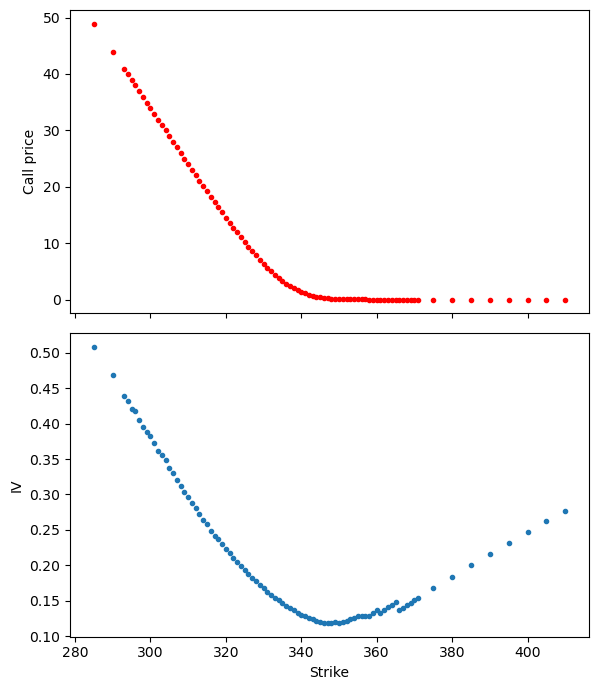

In [158]:
calls_no_na = calls.dropna()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,7), sharex=True)
ax1.plot(calls_no_na.strike, calls_no_na.midprice, "r.")
ax1.set_ylabel("Call price")
ax2.plot(calls_no_na.strike, calls_no_na.iv, ".")
ax2.set_ylabel("IV")
ax2.set_xlabel("Strike")
plt.tight_layout()
# plt.savefig("calls_to_iv.png", dpi=400)
plt.show()

In [159]:
calls_clean = calls.dropna().copy()
calls_clean["iv"] = gaussian_filter1d(calls_clean.iv, 3)

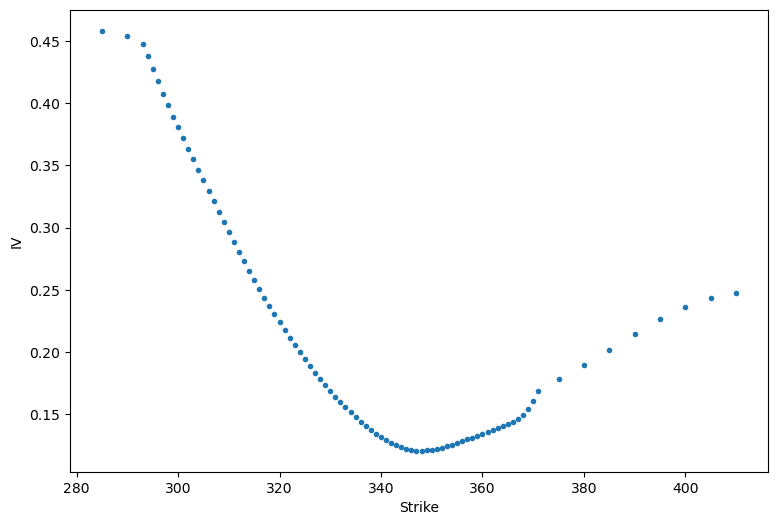

In [160]:
plot_vol_smile(calls_clean)

In [161]:
calls_clean = calls_clean[(calls_clean.strike > 300) & (calls_clean.strike < 375)]

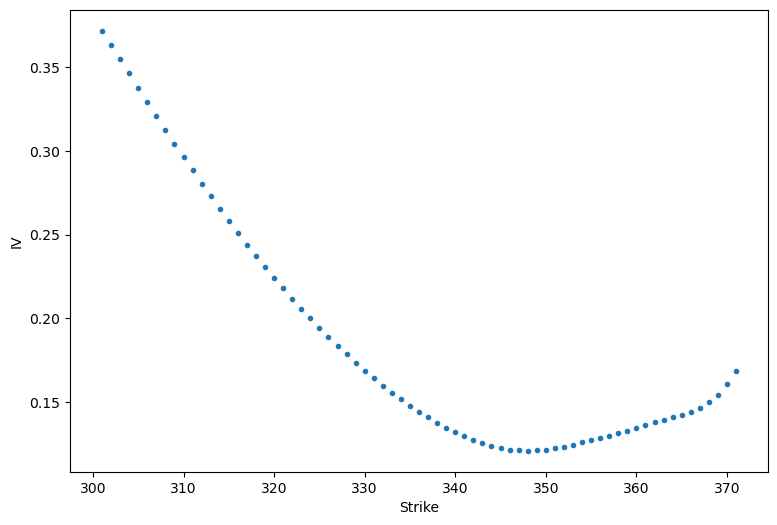

In [162]:
plot_vol_smile(calls_clean, savefig=False)

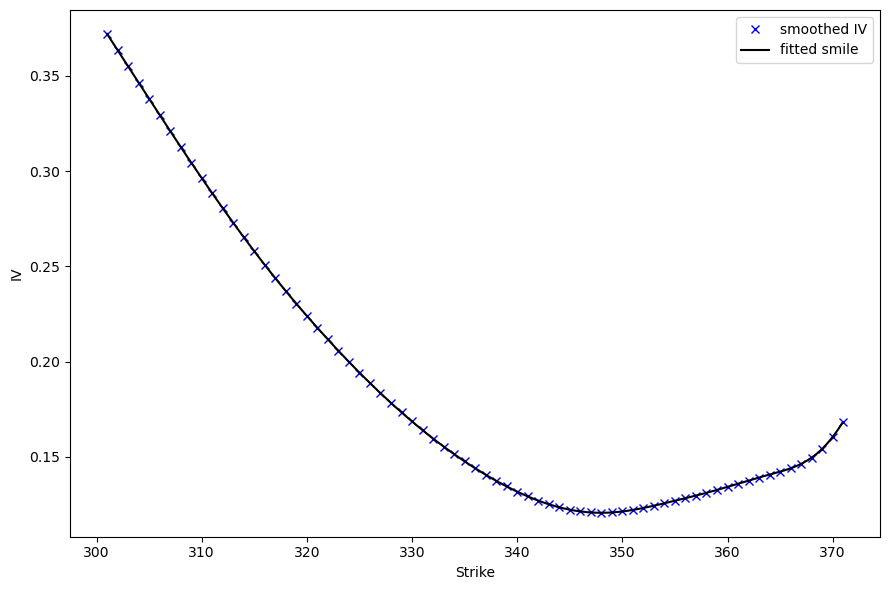

In [163]:
plt.figure(figsize=(9,6))
vol_surface = scipy.interpolate.interp1d(calls_clean.strike, calls_clean.iv, kind="cubic",
                                 fill_value="extrapolate")
x_new = np.arange(calls_clean.strike.min(), calls_clean.strike.max(), 0.1)
plt.plot(calls_clean.strike, calls_clean.iv, "bx", x_new, vol_surface(x_new), "k-");
plt.legend(["smoothed IV", "fitted smile"], loc="best")
plt.xlabel("Strike")
plt.ylabel("IV")
plt.tight_layout()
# plt.savefig("SPY_smile.png", dpi=300)
plt.show()

In [164]:
C_interp = call_value(S, x_new, vol_surface(x_new), t)

In [165]:
first_deriv = np.gradient(C_interp, x_new)
second_deriv = np.gradient(first_deriv, x_new)

In [166]:
def pdf2(Krange, S, t=0, r=0):
    # x is a range of strikes
    Crange = call_value(S, Krange, vol_surface(Krange), t, r)
    first_deriv = np.gradient(Crange, x_new, edge_order=0)
    second_deriv = np.gradient(first_deriv, x_new, edge_order=0)
    return np.exp(r * t) * second_deriv

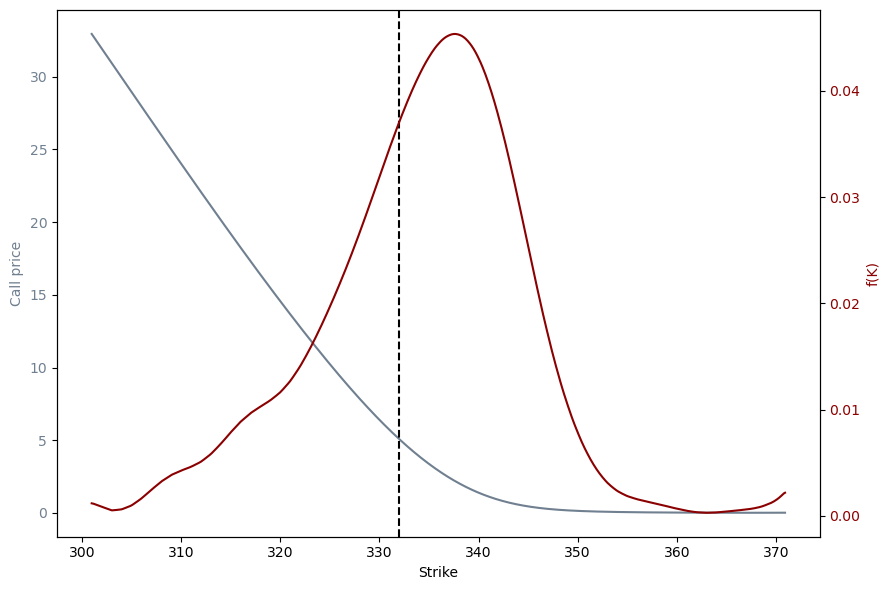

In [167]:
fig, ax1 = plt.subplots(figsize=(9,6))

col="slategrey"
ax1.set_xlabel('Strike')
ax1.set_ylabel('Call price', color=col)
ax1.plot(x_new, C_interp, color=col)
ax1.tick_params(axis='y', labelcolor=col)
ax1.axvline(332, color="k", linestyle="--")

ax2 = ax1.twinx()
col = 'darkred'
ax2.set_ylabel('f(K)', color=col)
ax2.plot(x_new, pdf2(x_new, S, t), color=col)
ax2.tick_params(axis='y', labelcolor=col)

fig.tight_layout()
# plt.savefig("volspace_pdf.png", dpi=300)
plt.show()

In [168]:
data = np.vstack([x_new, pdf2(x_new, S, t)]).T
data = data[(data[:, 0] < 360) & (data[:, 0] > 320)]
k, curve_pdf = np.hsplit(data, 2)

In [169]:
# Flatten the arrays if they are 2D
k_flat = k.flatten()
curve_pdf_flat = curve_pdf.flatten()

# Create a 2D array for the original PDF
original_pdf = np.column_stack((k_flat, curve_pdf_flat))

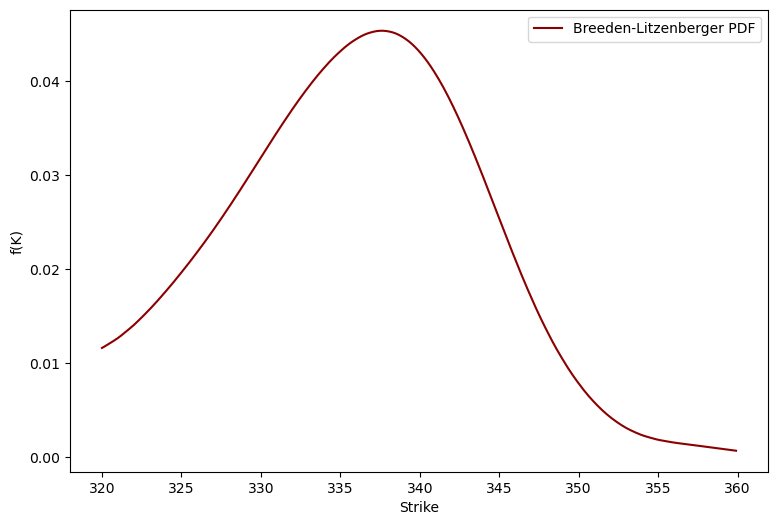

In [170]:
plt.figure(figsize=(9,6))
plt.plot(original_pdf[:, 0], original_pdf[:, 1], "darkred")
plt.xlabel("Strike")
plt.ylabel("f(K)")
plt.legend(["Breeden-Litzenberger PDF"], loc="best")
# plt.savefig("breeden_litzenberger_pdf.png", dpi=300)
plt.show()


# Change pdf beliefs

In [171]:
#Measure the area under the pdf curves

def compute_area(pdf_array):
    """
    Compute the area under a given PDF represented as a 2D array.

    Parameters:
    pdf_array (numpy.ndarray): A 2D array where the first column contains the x-values (e.g., strike prices)
                               and the second column contains the corresponding PDF values.

    Returns:
    float: The area under the PDF curve.
    """
    x_values = pdf_array[:, 0]
    pdf_values = pdf_array[:, 1]
    area = trapz(pdf_values, x_values)
    return area

# Example usage:
area_under_original_pdf = compute_area(original_pdf)
print("Area under the PDF:", area_under_original_pdf)


Area under the PDF: 0.8973977092102928


## Shift the pdf

In [172]:
# Shift the pdf to the right by "shift" units
shift = 5
shifted_pdf = np.column_stack((k + shift, curve_pdf_flat))

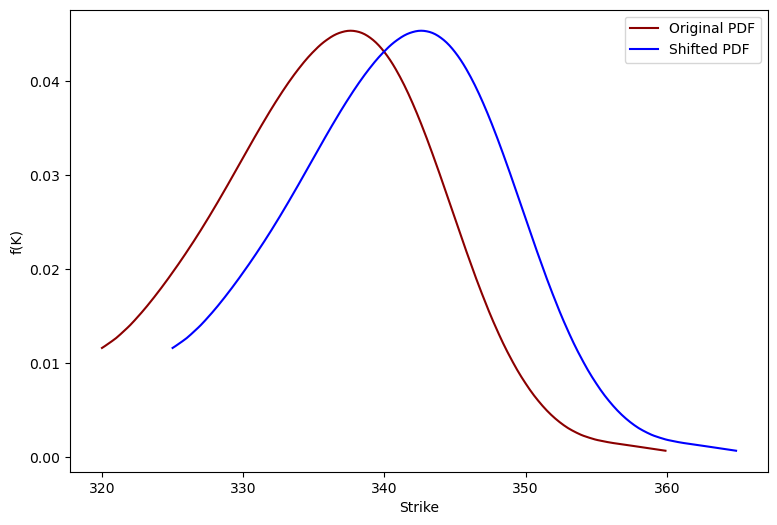

In [173]:
import matplotlib.pyplot as plt

# Assuming original_pdf and shifted_pdf are 2D arrays
# with the first column representing strike prices (k) and the second column representing PDF values (curve_pdf)

plt.figure(figsize=(9,6))

# Plot the original PDF
plt.plot(original_pdf[:, 0], original_pdf[:, 1], "darkred", label="Original PDF")

# Plot the shifted PDF
plt.plot(shifted_pdf[:, 0], shifted_pdf[:, 1], "blue", label="Shifted PDF")

plt.xlabel("Strike")
plt.ylabel("f(K)")
plt.legend(loc="best")
# plt.savefig("pdf_comparison.png", dpi=300)
plt.show()


In [174]:
#COMPUTE THE GROWTH OPTIMIZER PAYOFF


# Interpolate the original PDF
original_pdf_interp = interp1d(original_pdf[:, 0], original_pdf[:, 1], bounds_error=False, fill_value=0)

# Divide the shifted PDF by the interpolated original PDF
# Calculate the PDF values of the original PDF at the shifted strike prices
original_pdf_values_at_shifted = original_pdf_interp(shifted_pdf[:, 0])

# Handle division by zero by replacing zeros with a very small number
division = np.where(original_pdf_values_at_shifted != 0, shifted_pdf[:, 1] / original_pdf_values_at_shifted, 0)

# Create a function for the growth optimizer payoff
growth_optimizer_payoff = interp1d(shifted_pdf[:, 0], division, kind='linear', fill_value='extrapolate')

C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_584\3052951362.py:9: RuntimeWarning: divide by zero encountered in true_divide
  division = np.where(original_pdf_values_at_shifted != 0, shifted_pdf[:, 1] / original_pdf_values_at_shifted, 0)


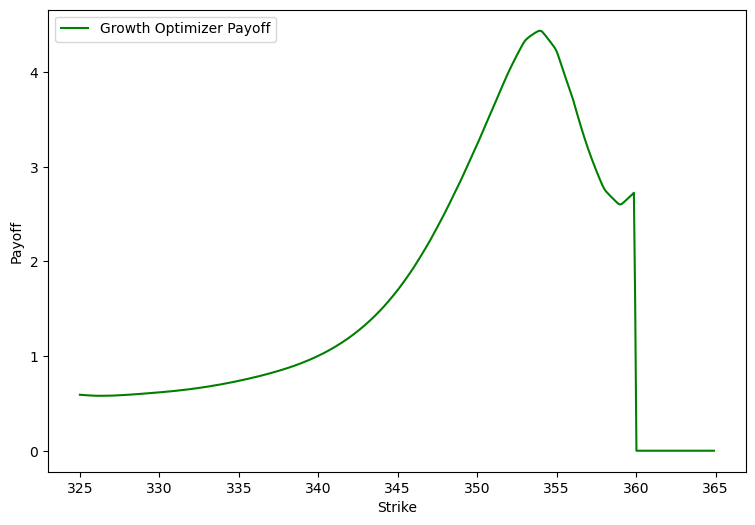

In [175]:
# Plot the growth optimizer payoff function
plt.figure(figsize=(9,6))

# Use a range of strike prices for plotting
strike_range = np.linspace(np.min(shifted_pdf[:, 0]), np.max(shifted_pdf[:, 0]), 500)
plt.plot(strike_range, growth_optimizer_payoff(strike_range), 'green', label='Growth Optimizer Payoff')

plt.xlabel("Strike")
plt.ylabel("Payoff")
plt.legend(loc="best")
# plt.savefig("growth_optimizer_payoff.png", dpi=300)
plt.show()

## Change volatility

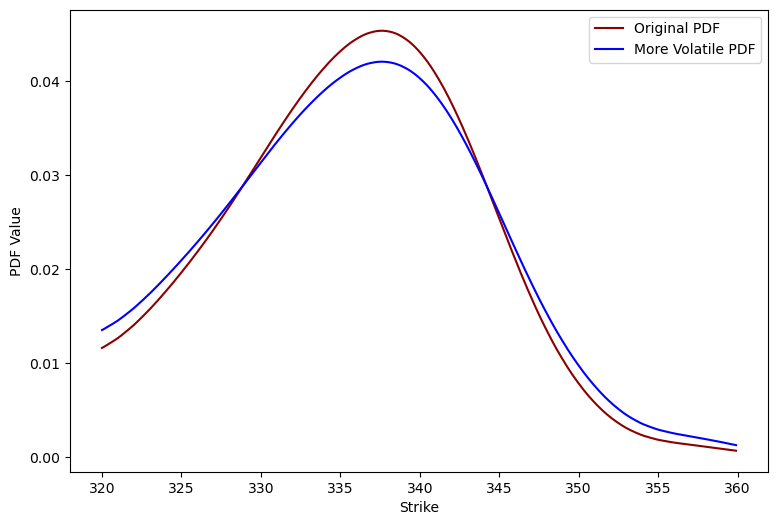

In [239]:
# Step 1: Increase volatility with a non-linear transformation
volatility_increase = 1.2  # Adjust this for more or less volatility
new_pdf_values = np.copy(original_pdf[:, 1])
new_pdf_values = np.power(new_pdf_values, 1 / volatility_increase)

# Step 2: Normalize the new PDF
original_area = trapz(original_pdf[:, 1], original_pdf[:, 0])
new_area = trapz(new_pdf_values, original_pdf[:, 0])
new_pdf_values *= (original_area / new_area)

# Step 3: Create the more volatile PDF
more_volatile_pdf = np.column_stack((original_pdf[:, 0], new_pdf_values))

# Step 4: Plot both PDFs for comparison
plt.figure(figsize=(9,6))
plt.plot(original_pdf[:, 0], original_pdf[:, 1], 'darkred', label='Original PDF')
plt.plot(more_volatile_pdf[:, 0], more_volatile_pdf[:, 1], 'blue', label='More Volatile PDF')
plt.xlabel('Strike')
plt.ylabel('PDF Value')
plt.legend()
plt.show()

In [240]:
#COMPUTE THE GROWTH OPTIMIZER PAYOFF

# Interpolate the original PDF
original_pdf_interp = interp1d(original_pdf[:, 0], original_pdf[:, 1], bounds_error=False, fill_value=0)

# Divide the more volatile PDF by the interpolated original PDF
# Calculate the PDF values of the original PDF at the more volatile PDF's strike prices
original_pdf_values_at_more_volatile = original_pdf_interp(more_volatile_pdf[:, 0])

# Perform the division
division = more_volatile_pdf[:, 1] / np.where(original_pdf_values_at_more_volatile != 0, 
                                              original_pdf_values_at_more_volatile, 1)

# Create a function for the growth optimizer payoff
growth_optimizer_payoff = interp1d(more_volatile_pdf[:, 0], division, kind='linear', fill_value='extrapolate')



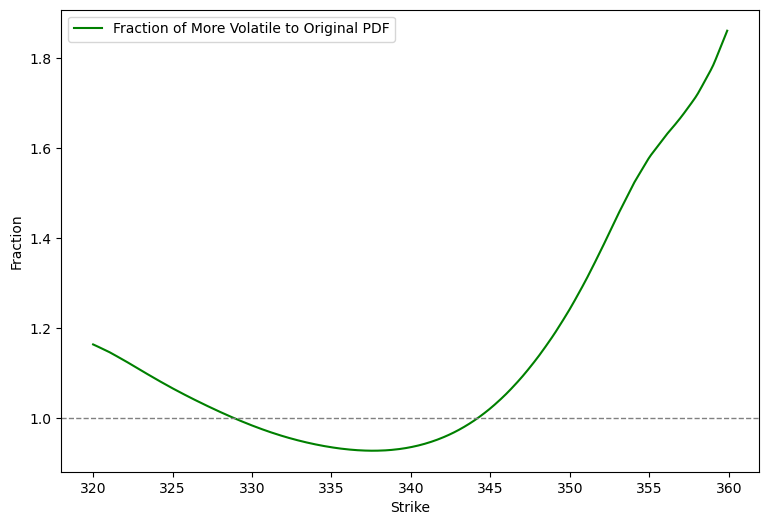

In [242]:
# Plot the function
plt.figure(figsize=(9,6))

# Use a range of strike prices for plotting
strike_range = np.linspace(np.min(more_volatile_pdf[:, 0]), np.max(more_volatile_pdf[:, 0]), 500)
plt.plot(strike_range, growth_optimizer_payoff(strike_range), 'green', label='Fraction of More Volatile to Original PDF')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Strike")
plt.ylabel("Fraction")
plt.legend(loc="best")
# plt.savefig("more_volatile_to_original_fraction.png", dpi=300)
plt.show()

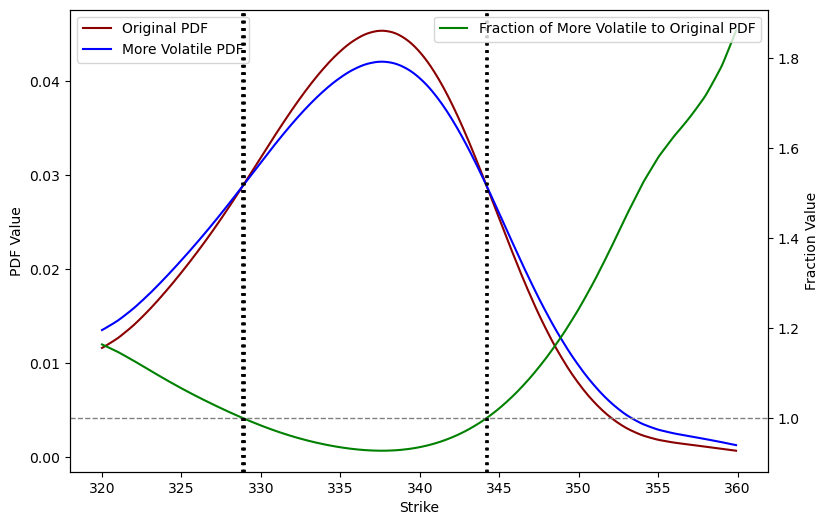

In [250]:
#PLOT TOGETHER WITH SCALED PDFs


plt.figure(figsize=(9,6))

# Plot the Original PDF and More Volatile PDF
plt.plot(original_pdf[:, 0], original_pdf[:, 1], 'darkred', label='Original PDF')
plt.plot(more_volatile_pdf[:, 0], more_volatile_pdf[:, 1], 'blue', label='More Volatile PDF')

plt.xlabel("Strike")
plt.ylabel("PDF Value")
plt.legend(loc="upper left")

# Create secondary y-axis for the fraction
ax2 = plt.gca().twinx()

# Calculate and Plot the Fraction of More Volatile to Original PDF on the secondary y-axis
strike_range = np.linspace(np.min(more_volatile_pdf[:, 0]), np.max(more_volatile_pdf[:, 0]), 1000)
fractions = growth_optimizer_payoff(strike_range)
ax2.plot(strike_range, fractions, 'green', label='Fraction of More Volatile to Original PDF')

# Add a horizontal line at y=1 for reference on the secondary y-axis
ax2.axhline(y=1, color='gray', linestyle='--', linewidth=1)
ax2.set_ylabel("Fraction Value")
ax2.legend(loc="upper right")

# Add more visible vertical dotted lines where the fraction is approximately 1
tolerance = 0.001  # Very small tolerance for precision
equal_points = strike_range[np.abs(fractions - 1) < tolerance]
for x in equal_points:
    plt.axvline(x=x, color='black', linestyle=':', linewidth=2)

plt.show()
